# Importing libraries

In [1]:
import os

from torch import nn
from torch.autograd import grad
import torch

from torch.utils.data import DataLoader
from torch import optim
from torch import autograd
from torch import nn
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import sampler
from argparse import ArgumentParser
#from wgan64x64 import *
from sklearn import metrics
from tqdm.auto import tqdm
import numpy as np
import time
import os
import sys
import random
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt


c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Enabling GPU capabilites

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"]= "max_split_size_mb:21"
key = "PYTORCH_CUDA_ALLOC_CONF"
value = os.getenv(key)

print(value)

max_split_size_mb:21


In [3]:
options_c     = 0 # <- normal class
options_alpha = 1
options_cuda  = '0'
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
        torch.cuda.set_device('cuda:{}'.format(options_cuda))
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

# device2 = torch.device('cuda:{}'.format(options_cuda))
# torch.cuda.set_device('cuda:{}'.format(options_cuda))

cuda:0


# Loading the train, validation and test data sets

In [4]:
MODE = 'wgan-gp'  # Valid options are dcgan, wgan, or wgan-gp

LAMBDA = 10  # Gradient penalty lambda hyperparameter
CRITIC_ITERS = 12  # How many critic iterations per generator iteration
BATCH_SIZE = 5  # Batch size

LATENT_SPACE_SIZE = 230

In [5]:
DIM = 160
OUTPUT_DIM = 3*160*160

TOP_CROP_POS = 50
LEFT_CROP_POS = 35

In [6]:
def one_class_dataloader(c, nw=0, bs=64):
    nw = 0
    # data_dir = '../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop
    # test_dir = '../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
    data_dir = '../../Images/june5Night/Positive'      #This is for the home laptop
    test_dir = '../../Images/june5Night/Evaluation'      #This is for the home laptop

    val_dir = '../../Images/june5Night/Validation/'      #This is for the home laptop
    
    transform = transforms.Compose([
            # transforms.RandomCrop(32, padding=4),
            # transforms.RandomHorizontalFlip(),
            transforms.Resize(255),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # transforms.Normalize((0.5, 0.5, 0.5),
            #                      (0.5, 0.5, 0.5)),
        ])

    dataset = datasets.ImageFolder(data_dir, transform = transform)
    trainloader = DataLoader(
        dataset, bs, num_workers=nw, pin_memory=True, drop_last=True) 
    
    dataset_test = datasets.ImageFolder(test_dir, transform = transform)
    dataloader_test = DataLoader(
        dataset_test, bs, num_workers=nw, pin_memory=True, drop_last=False) 
    
    dataset_val = datasets.ImageFolder(val_dir, transform = transform)
    dataloader_val = DataLoader(
        dataset_val, bs, num_workers=nw, pin_memory=True, drop_last=False) 


    # return trainloader, dataloader_test
    return trainloader, dataloader_test, dataloader_val

# Showing one sample of the training set images

In [7]:
dataloader, _, _ = one_class_dataloader(options_c, 0, BATCH_SIZE)

In [8]:
images, labels = next(iter(dataloader))
images = images.to(device)
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0])
tensor(0.0157, device='cuda:0') tensor(1., device='cuda:0')


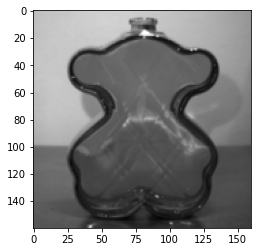

In [9]:
imgs_croped = transforms.functional.crop(images.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
single_img = imgs_croped[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.detach().cpu().numpy()

plt.imshow(single_img_numpy)

# Auxiliar model structures and functions

In [10]:
def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st


class MyConvo2d(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True,  stride=1, bias=True):
        super(MyConvo2d, self).__init__()
        self.he_init = he_init
        self.padding = int((kernel_size - 1)/2)
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size,
                              stride=1, padding=self.padding, bias=bias)

    def forward(self, input):
        output = self.conv(input)
        return output


class ConvMeanPool(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(ConvMeanPool, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init)

    def forward(self, input):
        output = self.conv(input)
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] +
                  output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        return output


class MeanPoolConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True):
        super(MeanPoolConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init)

    def forward(self, input):
        output = input
        output = (output[:, :, ::2, ::2] + output[:, :, 1::2, ::2] +
                  output[:, :, ::2, 1::2] + output[:, :, 1::2, 1::2]) / 4
        output = self.conv(output)
        return output


class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super(DepthToSpace, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size*block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, input_height, input_width, input_depth) = output.size()
        output_depth = int(input_depth / self.block_size_sq)
        output_width = int(input_width * self.block_size)
        output_height = int(input_height * self.block_size)
        t_1 = output.reshape(batch_size, input_height,
                             input_width, self.block_size_sq, output_depth)
        spl = t_1.split(self.block_size, 3)
        stacks = [t_t.reshape(batch_size, input_height,
                              output_width, output_depth) for t_t in spl]
        output = torch.stack(stacks, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(
            batch_size, output_height, output_width, output_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class UpSampleConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, he_init=True, bias=True):
        super(UpSampleConv, self).__init__()
        self.he_init = he_init
        self.conv = MyConvo2d(input_dim, output_dim,
                              kernel_size, he_init=self.he_init, bias=bias)
        self.depth_to_space = DepthToSpace(2)

    def forward(self, input):
        output = input
        output = torch.cat((output, output, output, output), 1)
        output = self.depth_to_space(output)
        output = self.conv(output)
        return output


class ResidualBlock(nn.Module):
    # ResidualBlock(dim, dim*2, 3, 'down', 64)
    def __init__(self, input_dim, output_dim, kernel_size, resample=None, hw=DIM):
        super(ResidualBlock, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.resample = resample
        self.bn1 = None
        self.bn2 = None
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        if resample == 'down':
            self.bn1 = nn.LayerNorm([input_dim, hw, hw])
            self.bn2 = nn.LayerNorm([input_dim, hw, hw])
        elif resample == 'up':
            self.bn1 = nn.BatchNorm2d(input_dim)
            self.bn2 = nn.BatchNorm2d(output_dim)
        elif resample == None:
            # TODO: ????
            self.bn1 = nn.BatchNorm2d(output_dim)
            self.bn2 = nn.LayerNorm([input_dim, hw, hw])
        else:
            raise Exception('invalid resample value')

        if resample == 'down':
            self.conv_shortcut = MeanPoolConv(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(
                input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = ConvMeanPool(
                input_dim, output_dim, kernel_size=kernel_size)
        elif resample == 'up':
            self.conv_shortcut = UpSampleConv(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = UpSampleConv(
                input_dim, output_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = MyConvo2d(
                output_dim, output_dim, kernel_size=kernel_size)
        elif resample == None:
            self.conv_shortcut = MyConvo2d(
                input_dim, output_dim, kernel_size=1, he_init=False)
            self.conv_1 = MyConvo2d(
                input_dim, input_dim, kernel_size=kernel_size, bias=False)
            self.conv_2 = MyConvo2d(
                input_dim, output_dim, kernel_size=kernel_size)
        else:
            raise Exception('invalid resample value')

    def forward(self, input):
        if self.input_dim == self.output_dim and self.resample == None:
            shortcut = input
        else:
            shortcut = self.conv_shortcut(input)

        output = input
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.conv_1(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.conv_2(output)

        return shortcut + output


class ReLULayer(nn.Module):
    def __init__(self, n_in, n_out):
        super(ReLULayer, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.linear = nn.Linear(n_in, n_out)
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.linear(input)
        output = self.relu(output)
        return output





# Building the generator and discriminator models

In [11]:
class FCGenerator(nn.Module):
    def __init__(self, FC_DIM=512):
        super(FCGenerator, self).__init__()
        self.relulayer1 = ReLULayer(128, FC_DIM)
        self.relulayer2 = ReLULayer(FC_DIM, FC_DIM)
        self.relulayer3 = ReLULayer(FC_DIM, FC_DIM)
        self.relulayer4 = ReLULayer(FC_DIM, FC_DIM)
        self.linear = nn.Linear(FC_DIM, OUTPUT_DIM)
        self.tanh = nn.Tanh()

    def forward(self, input):
        output = self.relulayer1(input)
        output = self.relulayer2(output)
        output = self.relulayer3(output)
        output = self.relulayer4(output)
        output = self.linear(output)
        output = self.tanh(output)
        return output

class GoodGenerator(nn.Module):
    def __init__(self, dim=DIM, output_dim=OUTPUT_DIM):
        super(GoodGenerator, self).__init__()

        self.dim = dim

        # self.ln1 = nn.Linear(128, 4*4*8*self.dim)
        self.ln1 = nn.Linear(LATENT_SPACE_SIZE, 10*10*8*self.dim)
        self.rb1 = ResidualBlock(8*self.dim, 8*self.dim, 3, resample='up')
        self.rb2 = ResidualBlock(8*self.dim, 4*self.dim, 3, resample='up')
        self.rb3 = ResidualBlock(4*self.dim, 2*self.dim, 3, resample='up')
        self.rb4 = ResidualBlock(2*self.dim, 1*self.dim, 3, resample='up')
        self.bn = nn.BatchNorm2d(self.dim)

        self.conv1 = MyConvo2d(1*self.dim, 3, 3)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # print("PEROFORMING __init__")
        self.initialize()

    def initialize(self):
        # print("PEROFORMING INITIALIZATION")
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, input):
        # print("PEROFORMING FORWARD FUNCTION")
        # print("input shape is: ", input.shape)
        output = self.ln1(input.contiguous())
        # print("self.ln1 shape is: ", output.shape)
        # output = output.view(-1, 8*self.dim, 4, 4)
        output = output.view(-1, 8*self.dim, 10, 10)
        # print("output.view shape is: ", output.shape)
        output = self.rb1(output)
        # print("self.rb1 shape is: ", output.shape)
        output = self.rb2(output)
        # print("self.rb2 shape is: ", output.shape)
        output = self.rb3(output)
        # print("self.rb3 shape is: ", output.shape)
        output = self.rb4(output)
        # print("self.rb4 shape is: ", output.shape)

        output = self.bn(output)
        # print("self.bn shape is: ", output.shape)
        output = self.relu(output)
        # print("self.relu shape is: ", output.shape)
        output = self.conv1(output)
        # print("self.conv1 shape is: ", output.shape)
        output = self.tanh(output)
        # print("self.tanh shape is: ", output.shape)
        # print("END OF FORWARD FUNCTION")
        # # output = output.view(-1, OUTPUT_DIM)
        return output

class GoodDiscriminator(nn.Module):
    def __init__(self, dim=DIM):
        super(GoodDiscriminator, self).__init__()

        self.dim = dim

        self.conv1 = MyConvo2d(3, self.dim, 3, he_init=False)
        self.rb1 = ResidualBlock(self.dim, 2*self.dim,
                                 3, resample='down', hw=DIM)
        self.rb2 = ResidualBlock(
            2*self.dim, 4*self.dim, 3, resample='down', hw=int(DIM/2))
        self.rb3 = ResidualBlock(
            4*self.dim, 8*self.dim, 3, resample='down', hw=int(DIM/4))
        self.rb4 = ResidualBlock(
            8*self.dim, 8*self.dim, 3, resample='down', hw=int(DIM/8))
        # self.ln1 = nn.Linear(4*4*8*self.dim, 1)
        self.ln1 = nn.Linear(10*10*8*self.dim, 1)
        # print("PEROFORMING __init__")
        self.initialize()

    def initialize(self):
        # print("PEROFORMING INITIALIZATION")
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def extract_feature(self, input):
        # print("PEROFORMING EXTRACTING FEATURES FUNCTION")
        # print("input shape is: ", input.shape)
        output = input.contiguous()
        # print("input.contigous() shape is: ", output.shape)
        output = output.view(-1, 3, DIM, DIM)
        # print("new shape of output is: ", output.shape)
        output = self.conv1(output)
        # print("after self.conv1, the shape of output is: ", output.shape)
        output = self.rb1(output)
        # print("after self.rb1, the shape of output is: ", output.shape)
        output = self.rb2(output)
        # print("after self.rb2, the shape of output is: ", output.shape)
        output = self.rb3(output)
        # print("after self.rb3, the shape of output is: ", output.shape)
        output = self.rb4(output)
        # print("after self.rb4, the shape of output is: ", output.shape)
        # # output = output.view(-1, 4*4*8*self.dim)
        output = output.view(-1, 10*10*8*self.dim)
        # print("after output.view, the shape of output is: ", output.shape)
        # print("END OF THE EXTRACTING FEATURES FUNCTION")  
        return output

    def forward(self, input):
        output = self.extract_feature(input)
        # print("after self.extract_feature, the shape of output is: ", output.shape)
        output = self.ln1(output)
        # print("after self.ln1(output), the shape of output is: ", output.shape)
        output = output.view(-1)
        # print("after output.view(-1), the shape of output is: ", output.shape)
        # print("PEROFORMING FORWARD")
        return output

# Building the encoder model

In [12]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
         # 15, 3, 160, 160.  Batch size, input channels, shape of the image.
        input_channels = 3              # number of channels of the input image
        output_channels = 55           # ~= 110/2. Shape of the input image divided by 2 approximately. 
        kernel_size = 9
        padding_val = 1
        stride_val = 5

        
        output_channels_layer2 = output_channels*2+5
        output_channels_layer3 = output_channels_layer2*2
        
        self.conv2d_1 = nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride_val, padding=padding_val)
        self.conv2d_2 = nn.Conv2d(output_channels, output_channels_layer2, kernel_size, stride=stride_val, padding=padding_val)
        self.conv2d_3 = nn.Conv2d(output_channels_layer2, output_channels_layer3, 5)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()


    def forward(self, x, flag = False):
        if flag:
            print("The FORWARD function is starting")

            print("The ENCODER part is executing")
            output = x
            print("The input image shape is: ", output.shape)
            output = self.conv2d_1(output)
            print("self.conv2d_1 shape is: ", output.shape)
            output = self.relu1(output)
            output = self.conv2d_2(output)
            print("self.conv2d_2 shape is: ", output.shape)
            output = self.relu2(output)
            output = self.conv2d_3(output)
            print("self.conv2d_3 shape is: ", output.shape)

            output = output.view(output.size(0), -1)
            print("output.view shape is: ", output.shape)

            print("Finish the FORWARD function")
        else:
            # print("The FORWARD function is starting")

            # print("The ENCODER part is executing")
            output = x
            # print("The input image shape is: ", output.shape)
            output = self.conv2d_1(output)
            # print("self.conv2d_1 shape is: ", output.shape)
            output = self.relu1(output)
            output = self.conv2d_2(output)
            # print("self.conv2d_2 shape is: ", output.shape)
            output = self.relu2(output)
            output = self.conv2d_3(output)
            # print("self.conv2d_3 shape is: ", output.shape)
            output = output.view(output.size(0), -1)
            # print("output.view shape is: ", output.shape)
        return output
    
    def show_modules(self):
        print("This is the show modules function")
        i = 0
        for m in self.modules():
            print(m)
            print("i is: ", i)
            print("print the next module")
            i = i +1
            
    def show_one_layer_weights(self, index):
        print("This is the one layer show function")
        i = 0
        for name, m in self.named_modules():
        # for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                if i == index:
                    print("Layer name is:", name)
                    print("The weights are: ", m.weight)
                i = i +1          

# Implementing F-AnoGan functions

In [13]:
sys.path.append(os.getcwd())        # Adding to the sys path, the current directory

torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.determinstic = False

In [14]:
def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(BATCH_SIZE, int(real_data.nelement()/BATCH_SIZE)).contiguous()
    alpha = alpha.view(BATCH_SIZE, 3, DIM, DIM)
    alpha = alpha.to(device)

    fake_data = fake_data.view(BATCH_SIZE, 3, DIM, DIM)
    interpolates = alpha * real_data.cuda().detach() + ((1 - alpha) * fake_data.detach())           # For home laptop. GPU capabilites
    # interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())                # For work laptop. No GPU
    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(
                                  disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty



# Implementing the training, validation and evaluation functions

In [15]:
   
def train_encoder(PreTrained=False,saveat=100,genstart=0):
    netG = GoodGenerator().to(device)
    netG.load_state_dict(torch.load(G_Model))                                     #For home laptop, using GPU
    # netG.load_state_dict(torch.load(G_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
    netG.eval()
    netD = GoodDiscriminator().to(device)
    netD.load_state_dict(torch.load(D_Model))
    # netD.load_state_dict(torch.load(D_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
    netD.eval()
    for p in netD.parameters():
        p.requires_grad = False
    for p in netG.parameters():
        p.requires_grad = False

    dataloader, _ , _= one_class_dataloader(options_c, 0, BATCH_SIZE)

    netE = Encoder().to(device)
    if PreTrained:
      netE.load_state_dict(torch.load(E_Model))

    optimizer = optim.Adam(netE.parameters(), 1e-4, (0.0, 0.9))

    crit = nn.MSELoss()
    # torch.cuda.empty_cache()
    total_losses_list= []
    mean_losses_list = []
    for iteration in tqdm(range(1+genstart, ENCODER_ITERS+1)):
        losses = []
        netE.train()
        print("iteration is: ", iteration)
        i=0
        for (x, _) in dataloader:
            x = x.to(device)
            imgs_croped = transforms.functional.crop(x.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
            code = netE(imgs_croped.cuda()) 
            rec_image = netG(code)
            d_input = torch.cat((imgs_croped, rec_image), dim=0)
            f_x, f_gx = netD.extract_feature(d_input).chunk(2, 0)
            loss = crit(rec_image, imgs_croped) + options_alpha * crit(f_gx, f_x.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            total_losses_list.append(loss.item())
            # print(i)
            i=i+1
        mean_losses_list.append(np.mean(losses))
        # print(iteration, np.mean(losses))
        netE.eval()
        rec_image = netG(netE(imgs_croped))
        d_input = torch.cat((imgs_croped, rec_image), dim=0)
        
        if iteration % saveat == 0:
            save_image(d_input*0.5+0.5, 'ForBottlesTrainingsV2/rec/rec_'+num2fixstr(iteration,4)+'.png')
        if iteration % saveat == 0 and iteration != 0:
            torch.save(netE.state_dict(), 'ForBottlesTrainingsV2/models/netE_' + num2fixstr(iteration,5) + '.pth')
    torch.save(netE.state_dict(), 'ForBottlesTrainingsV2/models/netE.pth')
    
    # open file
    with open('ForBottlesTrainingsV2/Encoder_total_losses_list.txt', 'w+') as g:
        # write elements of list
        for items in total_losses_list:
            g.write('%s\n' %items)
        print("total_losses_list written successfully")
    # close the file
    g.close() 



# Training WGAN

In [16]:
!mkdir wgangp
!mkdir rec
!mkdir models

A subdirectory or file wgangp already exists.
A subdirectory or file rec already exists.
A subdirectory or file models already exists.


In [17]:
print(torch.cuda.is_available())

True


In [18]:
genstart   = 0 # generación de partida (en caso de existir entrenamiento previo)
G_Model    = 'ForBottlesTrainingsV3/models/netG_' + num2fixstr(genstart,5) + '.pth'
D_Model    = 'ForBottlesTrainingsV3/models/netD_' + num2fixstr(genstart,5) + '.pth'

saveat     = 100   # cada cuantas iteraciones se guarda modelo
WGAN_ITERS = 700  # iteraciones máximas del entrenamiento

pretrained = genstart>0

print(G_Model)
print(D_Model)

ForBottlesTrainingsV3/models/netG_00000.pth
ForBottlesTrainingsV3/models/netD_00000.pth


In [19]:
# wgan_training(PreTrained=pretrained,saveat=saveat,genstart=genstart)

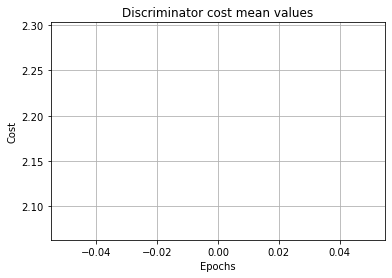

In [20]:
# Load data from the text file
with open("ForBottlesTrainingsV3/D_cost_mean_list.txt", "r") as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Discriminator cost mean values")
plt.grid(True)
plt.show()

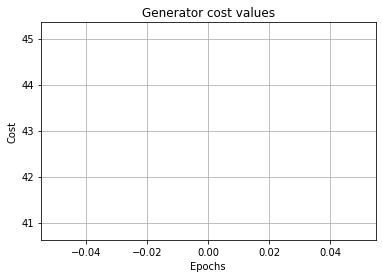

In [21]:
# Load data from the text file
with open("ForBottlesTrainingsV3/G_cost_list.txt", "r") as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Generator cost values")
plt.grid(True)
plt.show()

# Training Encoder

In [22]:
encstart      = 0
# ENCODER_ITERS = 20
# saveat        = 10 # cada cuantas iteraciones se guarda modelo
ENCODER_ITERS = 50
saveat        = 10 # cada cuantas iteraciones se guarda modelo

gen           = WGAN_ITERS #generación del generator a usar
G_Model       = 'ForBottlesTrainingsV3/models/netG_' + num2fixstr(gen,5) + '.pth'
D_Model       = 'ForBottlesTrainingsV3/models/netD_' + num2fixstr(gen,5) + '.pth'
E_Model       = 'ForBottlesTrainingsV3/models/netE_' + num2fixstr(encstart,5) + '.pth'

pretrained    = encstart>0


G_Model       = 'ForBottlesTrainingsV3/models/netG_00000.pth' 
D_Model       = 'ForBottlesTrainingsV3/models/netD_00000.pth'
E_Model       = 'ForBottlesTrainingsV3/models/netE_00000.pth'

print(G_Model)
print(D_Model)
print(E_Model)


ForBottlesTrainingsV3/models/netG_00000.pth
ForBottlesTrainingsV3/models/netD_00000.pth
ForBottlesTrainingsV3/models/netE_00000.pth


In [23]:
# train_encoder(PreTrained=pretrained,saveat=saveat)

In [24]:
PreTrained=pretrained
saveat=1

In [25]:
netG = GoodGenerator().to(device)
netG.load_state_dict(torch.load(G_Model))                                     #For home laptop, using GPU
# netG.load_state_dict(torch.load(G_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
netG.eval()
netD = GoodDiscriminator().to(device)
netD.load_state_dict(torch.load(D_Model))
# netD.load_state_dict(torch.load(D_Model, map_location=torch.device('cpu')))     #For work laptop, without using GPU
netD.eval()
for p in netD.parameters():
    p.requires_grad = False
for p in netG.parameters():
    p.requires_grad = False

dataloader, _ , _= one_class_dataloader(options_c, 0, BATCH_SIZE)

netE = Encoder().to(device)
if PreTrained:
    netE.load_state_dict(torch.load(E_Model))

optimizer = optim.Adam(netE.parameters(), 1e-4, (0.0, 0.9))

crit = nn.MSELoss()
# torch.cuda.empty_cache()
total_losses_list= []
mean_losses_list = []

# for iteration in tqdm(range(1+genstart, ENCODER_ITERS+1)):
for iteration in range(1):
    losses = []
    netE.train()
    print("iteration is: ", iteration)
    i=0
    for (x, _) in dataloader:
        if i==1:
            break
        x = x.to(device)
        imgs_croped = transforms.functional.crop(x.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
        code = netE(imgs_croped.cuda(),True) 
        print("The output's shape of the Encoder model is: ", code.shape)
        rec_image = netG(code)
        print("The output of the Generator model has shape: ", rec_image.shape)
        d_input = torch.cat((imgs_croped, rec_image), dim=0)
        print("The concatenation has shape: ", d_input.shape)
        f_x, f_gx = netD.extract_feature(d_input).chunk(2, 0)
        print("The discriminator features extraction of the each part of the concatenation has shape: ", f_x.shape)
        loss = crit(rec_image, imgs_croped) + options_alpha * crit(f_gx, f_x.detach())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        total_losses_list.append(loss.item())
        # print(i)
        i=i+1
    mean_losses_list.append(np.mean(losses))
    # print(iteration, np.mean(losses))
    netE.eval()
    rec_image = netG(netE(imgs_croped))
    d_input = torch.cat((imgs_croped, rec_image), dim=0)
    
    if iteration % saveat == 0:
        save_image(d_input*0.5+0.5, 'ForBottlesTrainingsV3/rec/rec_'+num2fixstr(iteration,4)+'.png')
    # if iteration % saveat == 0 and iteration != 0:
    if iteration % saveat == 0:
        torch.save(netE.state_dict(), 'ForBottlesTrainingsV3/models/netE_' + num2fixstr(iteration,5) + '.pth')
torch.save(netE.state_dict(), 'ForBottlesTrainingsV3/models/netE.pth')

# open file
with open('ForBottlesTrainingsV3/Encoder_total_losses_list.txt', 'w+') as g:
    # write elements of list
    for items in total_losses_list:
        g.write('%s\n' %items)
    print("total_losses_list written successfully")
# close the file
g.close() 

# open file
with open('ForBottlesTrainingsV3/Encoder_mean_losses_list.txt', 'w+') as d:
    # write elements of list
    for items in mean_losses_list:
        d.write('%s\n' %items)
    print("mean_losses_list written successfully")
# close the file
d.close() 

iteration is:  0
The FORWARD function is starting
The ENCODER part is executing
The input image shape is:  torch.Size([5, 3, 160, 160])
self.conv2d_1 shape is:  torch.Size([5, 55, 31, 31])
self.conv2d_2 shape is:  torch.Size([5, 115, 5, 5])
self.conv2d_3 shape is:  torch.Size([5, 230, 1, 1])
output.view shape is:  torch.Size([5, 230])
Finish the FORWARD function
The output's shape of the Encoder model is:  torch.Size([5, 230])
The output of the Generator model has shape:  torch.Size([5, 3, 160, 160])
The concatenation has shape:  torch.Size([10, 3, 160, 160])
The discriminator features extraction of the each part of the concatenation has shape:  torch.Size([5, 128000])
total_losses_list written successfully
mean_losses_list written successfully


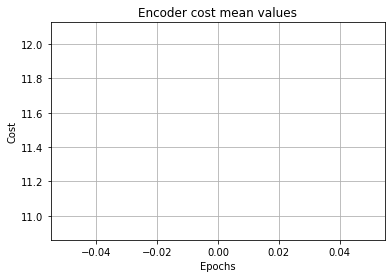

In [26]:
# Load data from the text file
with open("ForBottlesTrainingsV3/Encoder_mean_losses_list.txt", "r") as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Encoder cost mean values")
plt.grid(True)
plt.show()

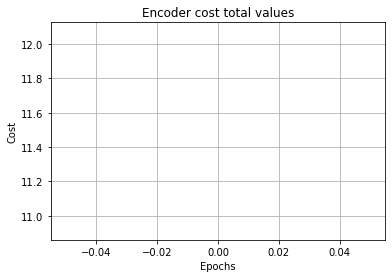

In [27]:
# Load data from the text file
with open("ForBottlesTrainingsV3/Encoder_total_losses_list.txt", "r") as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Encoder cost total values")
plt.grid(True)
plt.show()